In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

# tr the VAE on MNIST digits
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32') / 255., x_te.astype('float32') / 255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

# Hyperparameters
batch_size = 100
intermediate_dim, latent_dim = 256, 2

C:\Users\lyeoni\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#encoder
x = Input(batch_shape = (batch_size, x_tr.shape[1]))
x_encoded = Dense(intermediate_dim, activation = 'relu')(x)
mu = Dense(latent_dim)(x_encoded)
sigma = Dense(latent_dim)(x_encoded)

print(mu)
print(sigma)

Tensor("dense_2/BiasAdd:0", shape=(100, 2), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(100, 2), dtype=float32)


In [3]:
def sampling(args):
    mu, sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return mu + K.exp(sigma) * epsilon
 
# note that “output_shape” isn’t necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([mu, sigma])

#latent hidden state
print(z)

Tensor("lambda_1/add:0", shape=(100, 2), dtype=float32)


In [4]:
#decoder
# we instantiate these layers separately so as to reuse them later
z_decoder = Dense(intermediate_dim, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder(z)
y_decoded = y_decoder(z_decoded)

print(y_decoded)

Tensor("dense_5/Sigmoid:0", shape=(100, 784), dtype=float32)


In [5]:
#loss
xent_loss = objectives.binary_crossentropy(x, y_decoded) * 784
kl_loss = 0.5 * K.sum(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
vae_loss = xent_loss - kl_loss

vae = Model(x, y_decoded)
vae.add_loss(vae_loss)
vae.compile(optimizer= 'rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (100, 784)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (100, 256)           200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (100, 2)             514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (100, 2)             514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

C:\Users\lyeoni\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Output "dense_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_5" during training.
  


In [6]:
# #loss
# def vae_loss(x, x_decoded_mean):
#     xent_loss = objectives.binary_crossentropy(x, x_decoded_mean) * 784
#     kl_loss = 0.5 * K.sum(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
# #     kl_loss = K.mean(kl_loss, axis=-1)
# #     kl_loss = -0.5 * K.sum(1 + sigma — K.square(mu) — K.exp(sigma), axis=-1)
#     return xent_loss - kl_loss

# vae = Model(x, y_decoded)
# vae.compile(optimizer= 'rmsprop', loss=vae_loss)
# vae.summary()

In [7]:
# epoch = 50
# vae.fit(x_tr, x_tr,
#         shuffle=True,
#         epochs=epoch,
#         batch_size=batch_size,
#         validation_data=(x_te, x_te),verbose=1)
epoch = 50
vae.fit(x_tr,
        shuffle=True,
        epochs=epoch,
        batch_size=batch_size,
        validation_data=(x_te, None),verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 72us/step - loss: 209.6577 - val_loss: 182.0005
Epoch 2/50
60000/60000 [==============================] - 2s 34us/step - loss: 176.4295 - val_loss: 172.3805
Epoch 3/50
60000/60000 [==============================] - 2s 35us/step - loss: 170.2109 - val_loss: 167.7915
Epoch 4/50
60000/60000 [==============================] - 2s 34us/step - loss: 166.4380 - val_loss: 164.3282
Epoch 5/50
60000/60000 [==============================] - 2s 33us/step - loss: 163.6368 - val_loss: 161.9125
Epoch 6/50
60000/60000 [==============================] - 2s 33us/step - loss: 161.3051 - val_loss: 159.9339
Epoch 7/50
60000/60000 [==============================] - 2s 33us/step - loss: 159.4605 - val_loss: 158.5067
Epoch 8/50
60000/60000 [==============================] - 2s 33us/step - loss: 158.1302 - val_loss: 157.4764
Epoch 9/50
60000/60000 [==============================] - 2s 34us/step - loss:

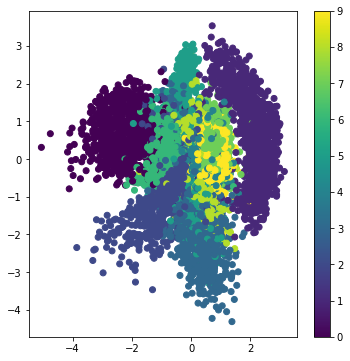

In [8]:
# build a model to project inputs on the latent space
encoder = Model(x, mu)

# display a 2D plot of the digit classes in the latent space
x_te_encoded = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_encoded[:, 0], x_te_encoded[:, 1], c=y_te)
plt.colorbar()
plt.show()

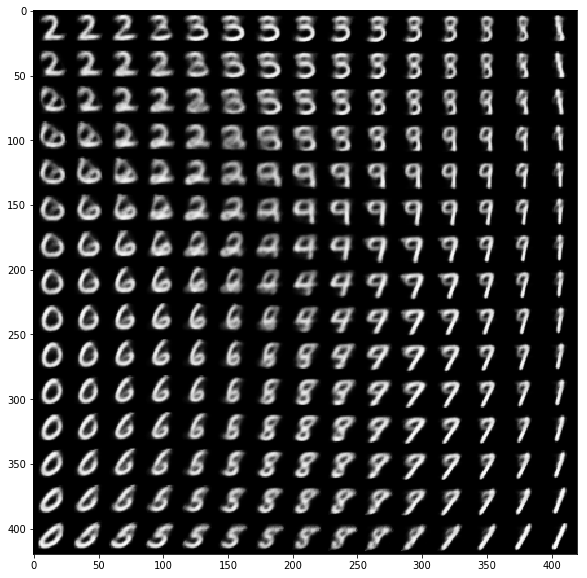

In [9]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = z_decoder(decoder_input)
_x_decoded_mean = y_decoder(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()